 The code is a complete pipeline for fine-tuning a geospatial Foundation Model (Prithvi EO 2.0) to detect fire severity using satellite imagery.
It involves three main time steps: Pre-fire, Post-fire, and a "Delta" (difference) frame.

#Environment Setup & Cleaning
This section ensures the Google Colab environment is clean and has the specific library versions needed for terratorch (the library containing the Prithvi model).

In [ ]:
# CELL 0: RESTART RUNTIME FIRST!
# ============================================================================
"""
IMPORTANT: Go to Runtime -> Restart runtime
Then run this cell to clear everything
"""
import torch
torch.cuda.empty_cache() # Clears GPU memory to prevent "Out of Memory" errors.
import gc
gc.collect()  # Python garbage collection to free up RAM.

print("✅ CUDA cache cleared")

✅ CUDA cache cleared


In [ ]:
# Uninstall conflicting packages
!pip uninstall -y numpy scipy pytorch-lightning lightning -q  # Uninstalling current versions to prevent conflicts

# Install compatible versions
!pip install numpy==1.26.4 -q   # Older numpy is often required for specific PyTorch versions
!pip install scipy==1.13.1 -q
!pip install pytorch-lightning==2.1.0 -q   # Specific Lightning version for stability

# Install other dependencies
!pip install segmentation-models-pytorch -q   # For Dice Loss and U-Net utilities
!pip install terratorch tensorboard scikit-learn -q  # Terratorch contains the Prithvi model

print("✅ Package installation complete!")
print("⚠️  Now RESTART RUNTIME again before running the rest of the code")
print("   (Runtime -> Restart runtime)")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 46.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.7.0 requires scipy>=1.12.0, which is not installed.
scs 3.2.11 requires scipy, which is not installed.
spglm 1.1.0 requires scipy>=1.8, which is not installed.
access 1.1.10.post3 requires scipy>=1.14.1, which is not installed.
albumentations 2.0.8 requires scipy>=1.10.0, which is not installed.
sklearn-pandas 2.2.0 requires scipy>=1.5.1, which is not installed.
esda 2.8.1 requires scipy>=1.12, which is not installed.
spint 1.0.7 requires scipy>=0.11, which is not installed.
quantecon 0.10.1 requires scipy>=1.5.0, which is not installed.
cuml-cu12 25.10.0 requires scipy>=1.8.0, which is not installed.
xgboost 3.1.3 requires scipy, which is not instal

# Imports & Hardware Check


In [ ]:
# ============================================================================
# STEP 3: After Second Restart, Run This Cell
# ============================================================================

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import numpy as np
import torch   # ... (standard PyTorch imports for Neural Networks and Data loading)
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from terratorch.models import EncoderDecoderFactory # The factory to build the Prithvi Model
from sklearn.model_selection import train_test_split   # ... (metrics and plotting imports)
from sklearn.metrics import f1_score, classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp

print(f"✅ PyTorch: {torch.__version__}")
print(f"✅ Lightning: {pl.__version__}")
print(f"✅ NumPy: {np.__version__}")
print(f"✅ CUDA: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


✅ PyTorch: 2.9.0+cu126
✅ Lightning: 2.1.0
✅ NumPy: 2.2.6
✅ CUDA: True
✅ GPU: Tesla T4


# Data Downloading & Extraction
This section retrieves the dataset prepared specifically for this task.

In [ ]:
import gdown

url = "https://drive.google.com/uc?id=1f9OQp5kQ5eem65G6fjUCb5f37KUqurbI" # # The ID of the Google Drive file containing the dataset use your own data

output = "data.zip"

gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1f9OQp5kQ5eem65G6fjUCb5f37KUqurbI
From (redirected): https://drive.google.com/uc?id=1f9OQp5kQ5eem65G6fjUCb5f37KUqurbI&confirm=t&uuid=8c051c81-a7e5-40a9-a984-0990b84f949d
To: /content/data.zip
100%|██████████| 192M/192M [00:04<00:00, 40.9MB/s]


'data.zip'

In [ ]:
import zipfile

with zipfile.ZipFile("data.zip", 'r') as zip_ref: # Unzips contents into a folder named "data"
    zip_ref.extractall("data")

import os

os.remove("data.zip")  # Deletes the zip file to save space


In [ ]:
import os

for root, dirs, files in os.walk("data"):
    level = root.replace("data", "").count(os.sep)   # to check the data
    indent = " " * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    for f in files:
        print(f"{indent}  {f}")


data/
  prithvi_data_final_withdelta/
    temporal_images/
      chip_000013.npy
      chip_000082.npy
      chip_000098.npy
      chip_000095.npy
      chip_000024.npy
      chip_000005.npy
      chip_000074.npy
      chip_000034.npy
      chip_000046.npy
      chip_000084.npy
      chip_000065.npy
      chip_000018.npy
      chip_000090.npy
      chip_000050.npy
      chip_000105.npy
      chip_000087.npy
      chip_000092.npy
      chip_000060.npy
      chip_000026.npy
      chip_000010.npy
      chip_000030.npy
      chip_000027.npy
      chip_000029.npy
      chip_000020.npy
      chip_000011.npy
      chip_000051.npy
      chip_000045.npy
      chip_000001.npy
      chip_000078.npy
      chip_000057.npy
      chip_000054.npy
      chip_000035.npy
      chip_000015.npy
      chip_000058.npy
      chip_000040.npy
      chip_000055.npy
      chip_000014.npy
      chip_000061.npy
      chip_000079.npy
      chip_000086.npy
      chip_000016.npy
      chip_000107.npy
      chip_000071

# Dataset Definition
This is a custom Pytorch Dataset class. It tells the computer how to read a single file from the disk.

In [ ]:
# ============================================================================
# CHANGE 1: Update Dataset Class (validation only)
# ============================================================================

class FireSeverityDataset(Dataset):
    """Dataset for temporal fire severity prediction"""

    def __init__(self, image_dir, mask_dir, chip_ids):
    # Stores the folder paths and the list of file IDs (chip_ids)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.chip_ids = chip_ids

    def __len__(self):
        return len(self.chip_ids)

    def __getitem__(self, idx):
        chip_id = self.chip_ids[idx]
        # Loads the input image (Satellite data)
        # Shape: (3, 6, 224, 224) -> 3 Time steps, 6 Spectral Bands, Height, Width

        # ✅ CHANGE: Now loads (3, 6, 224, 224) instead of (2, 6, 224, 224)
        image = np.load(os.path.join(self.image_dir, f"{chip_id}.npy"))

        # Loads the target mask (The ground truth map of fire severity)

        mask = np.load(os.path.join(self.mask_dir, f"{chip_id}.npy"))

        # Converts Numpy arrays to PyTorch Tensors (Float for images, Long/Integer for masks)
        image = torch.from_numpy(image).float()
        mask = torch.from_numpy(mask).long()

        return {'image': image, 'mask': mask}


# Data Module.
 Think of this class as the "Logistics Manager" for your project.

While the Dataset class (which we looked at previously) knows how to read one specific image, this DataModule knows how to handle all the images, split them into groups, and feed them to the model in batches efficiently.

In [ ]:
# ============================================================================
# DATA MODULE
# ============================================================================

class FireSeverityDataModule(pl.LightningDataModule):  #This inherits from PyTorch Lightning. It standardizes how data is loaded, making the code cleaner and easier to share.
    """Data module for fire severity dataset"""

    def __init__(self, data_dir, batch_size=8, num_workers=2, val_split=0.2):
        super().__init__()
        # Storing configuration variables

        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split = val_split
        # Define where the images and masks are located inside the main data folder

        self.image_dir = os.path.join(data_dir, 'temporal_images')
        self.mask_dir = os.path.join(data_dir, 'masks')

    def setup(self, stage=None):
        # 1. Get a list of every single file in the image directory
        all_files = os.listdir(self.image_dir)
        # 2. Clean the filenames to get just the ID (e.g., remove ".npy")
        all_chip_ids = [f.replace('.npy', '') for f in all_files]
        # 3. Randomly split the IDs into two lists: Train (80%) and Val (20%)
        # random_state=42 ensures the split is the same every time you run it.
        train_ids, val_ids = train_test_split(
            all_chip_ids, test_size=self.val_split, random_state=42
        )
        # 4. Create the actual Dataset objects using the lists of IDs we just made
        self.train_dataset = FireSeverityDataset(
            self.image_dir, self.mask_dir, train_ids
        )
        self.val_dataset = FireSeverityDataset(
            self.image_dir, self.mask_dir, val_ids
        )
        # Print stats so you know it worked
        print(f"✅ Train: {len(self.train_dataset)} samples")
        print(f"✅ Val: {len(self.val_dataset)} samples")

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,   # e.g., 8 images at a time
            shuffle=True,   # IMPORTANT: Shuffles data every epoch so the model doesn't memorize the order
            num_workers=self.num_workers,   # Uses 2 CPU cores to prepare data in parallel
            pin_memory=True,    # Speeds up transfer from CPU RAM to GPU RAM
            # Keeps the CPU workers alive between epochs to save startup time
            persistent_workers=True if self.num_workers > 0 else False
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,   # IMPORTANT: We do NOT shuffle validation data. We want consistent results.
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=True if self.num_workers > 0 else False
        )


# Class Weights Calculation
Satellite data is "imbalanced." Most pixels are "Unburned" (Class 0), while "Extreme Fire" (Class 4) is rare. If we don't fix this, the model will just predict "Unburned" everywhere and get high accuracy but fail at its job.

In [ ]:
# ============================================================================
# COMPUTE CLASS WEIGHTS
# ============================================================================

def compute_class_weights(data_dir, ignore_index=255):
  # ... (code iterates through all mask files) ...
    """Compute class weights from dataset"""
    print("\n📊 Computing class weights...")

    mask_dir = os.path.join(data_dir, 'masks')
    all_labels = []

    for mask_file in tqdm(os.listdir(mask_dir), desc="Scanning masks"):
        mask = np.load(os.path.join(mask_dir, mask_file))
        valid_pixels = mask[mask != ignore_index]
        all_labels.extend(valid_pixels.tolist())
    # Calculates how frequent each class is
    unique, counts = np.unique(all_labels, return_counts=True)
    print(f"\nClass distribution: {dict(zip(unique, counts))}")

    # Compute balanced weights
    total = len(all_labels)
    num_classes = 5
    weights = []

    for cls in range(num_classes):
        if cls in unique:
            cls_count = counts[unique == cls][0]
        # Formula: Total_Pixels / (Num_Classes * Count_of_Specific_Class)
        # This gives rare classes a HIGHER weight and common classes a LOWER weight.
            weight = total / (num_classes * cls_count)
        else:
            weight = 1.0
        weights.append(weight)

    weights = torch.tensor(weights, dtype=torch.float32)
    print(f"Class weights: {weights.numpy()}")

    return weights


#The Model (PrithviFireSegmentation)
This is the core logic. It uses PyTorch Lightning to organize the code.


In [ ]:
# ============================================================================
# CHANGE 2: Update Model to Accept 3 Frames
# ============================================================================

class PrithviFireSegmentation(pl.LightningModule):
    """Lightning module with delta channel support"""

    def __init__(
        self,
        num_classes=5,
        learning_rate=1e-4,
        weight_decay=0.01,
        class_weights=None,
        ignore_index=255,
        freeze_backbone_epochs=5
    ):
        super().__init__()
        # Saves parameters like 'learning_rate' so they are logged to TensorBoard automatically
        self.save_hyperparameters(ignore=['class_weights'])
        # We will freeze the main "brain" (backbone) for the first 5 epochs
        self.freeze_backbone_epochs = freeze_backbone_epochs
        self.backbone_frozen = True

        # Build model
        factory = EncoderDecoderFactory()
        self.model = factory.build_model(
            task="segmentation",    #The specific task here its segmentation (other ex. classification)
            backbone="prithvi_eo_v2_tiny_tl",   # The specific Foundation Model version
            decoder="UperNetDecoder",   # A sophisticated head for segmentation
            num_classes=num_classes,   # 5 classes: Unburned, Low, Moderate, High, Extreme
            backbone_kwargs={
                "in_channels": 6,  # Blue, Green, Red, NIR, SWIR1, SWIR2
                "pretrained": True,  # Download weights pre-trained on global data
                "num_frames": 3  # IMPORTANT: 3 frames (Pre, Post, Delta) (delta = post - pre)
            }
        )

        # Register class weights
        if class_weights is not None:
            self.register_buffer("class_weights", class_weights)
        else:
            self.class_weights = None
        # 1. CrossEntropyLoss: Good for general classification.
        # We use class_weights to tell it to pay more attention to rare classes (Extreme Fire).
        self.ce_loss = nn.CrossEntropyLoss(
            weight=self.class_weights,
            ignore_index=ignore_index
        )
        # 2. DiceLoss: Good for segmentation.
        # It cares about the "overlap" shapes. It ignores the background (Unburned)
        # and focuses on getting the burn shapes correct.
        self.dice_loss = smp.losses.DiceLoss(
            mode="multiclass",
            from_logits=True,
            ignore_index=ignore_index,
            classes=[1, 2, 3, 4]
        )

    def forward(self, x):
        # Transpose from (B, T, C, H, W) to (B, C, T, H, W)
        # Input x comes in as: (Batch, Time=3, Channels=6, Height, Width)
        # Prithvi expects:     (Batch, Channels=6, Time=3, Height, Width)

        # The .permute() command rearranges the dimensions to match what Prithvi wants.
        x = x.permute(0, 2, 1, 3, 4)

        # We pass the rearranged data into the model
        output = self.model(x)

        # Safety check: Different versions of the library return output differently.
        # This block ensures we just extract the raw prediction scores (logits).

        if hasattr(output, 'output'):
            return output.output
        elif isinstance(output, dict):
            return output['output']
        else:
            return output

    # The following multi-line comment block was causing an indentation issue.
    # It has been moved to be part of the `on_train_epoch_start` method's docstring
    # or removed if it was only a general comment.

    def on_train_epoch_start(self):
        """Unfreeze backbone after specified epochs
        This is a sophisticated fine-tuning technique. We don't want to destroy the pre-trained knowledge immediately.

        Epoch 0-5: We freeze the "Backbone" (the deep brain). We only update the "Decoder" (the eyes/hands).
        This aligns the new fire tasks with the pre-existing knowledge.

        Epoch 5+: We unfreeze the backbone and let the whole model learn.
        """
        # If we hit epoch 5, we unlock the backbone
        if self.backbone_frozen and self.current_epoch >= self.freeze_backbone_epochs:
            print(f"\n🔓 Unfreezing backbone at epoch {self.current_epoch}")
            # ✅ FIX: Access encoder instead of backbone
            if hasattr(self.model, 'encoder'):
              # Turn gradients back ON. Now the Foundation Model itself adapts to fire data.
                for param in self.model.encoder.parameters():
                    param.requires_grad = True
            elif hasattr(self.model, 'backbone'):
                for param in self.model.backbone.parameters():
                    param.requires_grad = True
            else:
                # Fallback: unfreeze all parameters
                for param in self.model.parameters():
                    param.requires_grad = True
            self.backbone_frozen = False

    def on_train_start(self):
        """Freeze backbone initially"""
        print(f"🔒 Freezing backbone for first {self.freeze_backbone_epochs} epochs")
        # Iterate through the encoder/backbone parameters and turn off gradients.
        # The model will NOT learn here, preserving pre-trained weights.
        # ✅ FIX: Access encoder instead of backbone
        if hasattr(self.model, 'encoder'):
            for param in self.model.encoder.parameters():
                param.requires_grad = False
        elif hasattr(self.model, 'backbone'):
            for param in self.model.backbone.parameters():
                param.requires_grad = False
        else:
            print("⚠️ Could not find encoder/backbone - training all parameters from start")

    def training_step(self, batch, batch_idx):
        images, masks = batch['image'], batch['mask']

        # ✅ CHANGE: Update validation
        # 🚨 SAFETY CHECK: Ensure we are actually feeding 3 time steps (Pre, Post, Delta)
        assert images.shape[1] == 3, f"Expected 3 time steps, got {images.shape[1]}"  # Changed from 2 to 3
        assert images.shape[2] == 6, f"Expected 6 channels, got {images.shape[2]}"
        # 1. Guess: Ask the model for predictions (logits)
        logits = self(images)
        # 2. Grade: Calculate how wrong the model is
        ce_loss = self.ce_loss(logits, masks)
        dice_loss = self.dice_loss(logits, masks)
        # Combine losses. We give Dice loss 0.8 weight to emphasize accurate shapes.
        #loss = ce_loss + 0.5 * dice_loss
        loss = ce_loss + 0.8 * dice_loss


        # Accuracy on valid pixels only
        # 3. Check Accuracy:
        # We ignore "255" pixels (invalid data) when calculating accuracy
        valid_mask = masks != 255
        if valid_mask.sum() > 0:
            preds = torch.argmax(logits, dim=1)
            accuracy = (preds[valid_mask] == masks[valid_mask]).float().mean()
        else:
            accuracy = torch.tensor(0.0)

        # 4. Report Card: Send stats to the progress bar and logs
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_ce', ce_loss, on_step=False, on_epoch=True)
        self.log('train_dice', dice_loss, on_step=False, on_epoch=True)
        self.log('train_acc', accuracy, on_step=True, on_epoch=True, prog_bar=True)

        return loss   # The optimizer uses this value to update weights

    def validation_step(self, batch, batch_idx):
        """
        This runs at the end of every epoch. It is the "Exam" phase.
        It uses the same logic as training, but it doesn't update the model weights.
        """
        images, masks = batch['image'], batch['mask']

        logits = self(images)

        ce_loss = self.ce_loss(logits, masks)
        dice_loss = self.dice_loss(logits, masks)
        loss = ce_loss + 0.8 * dice_loss

        valid_mask = masks != 255
        if valid_mask.sum() > 0:
            preds = torch.argmax(logits, dim=1)
            accuracy = (preds[valid_mask] == masks[valid_mask]).float().mean()
        else:
            accuracy = torch.tensor(0.0)

        self.log('val_loss', loss, on_epoch=True, prog_bar=True)   #Used by EarlyStopping to decide when to quit
        self.log('val_ce', ce_loss, on_epoch=True)
        self.log('val_dice', dice_loss, on_epoch=True)
        self.log('val_acc', accuracy, on_epoch=True, prog_bar=True)

        return loss

    def configure_optimizers(self):
      # AdamW is a standard, robust optimizer for Transformers
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay
        )
        # Scheduler: Cosine Annealing
        # Start with a high learning rate, then slowly lower it in a wave pattern.
        # This helps the model settle into a good solution without overshooting.
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=30, eta_min=1e-6
        )

        return {
            'optimizer': optimizer,
            'lr_scheduler': {'scheduler': scheduler, 'interval': 'epoch'}
        }


# Evaluation
This function, evaluate_model, is the Report Card Generator. After the model has finished training, this function runs through the test data to calculate exactly how well the model performs.

It is designed to handle the specific challenges of satellite segmentation, such as ignoring bad data pixels and handling class imbalance (where most of the map is unburned).

1. Iterate through validation images.
2. Ignore garbage pixels (value 255).
3. Collect millions of valid pixel predictions.
4. Calculate F1 scores (General performance).
5. Calculate "Burned Only" F1 (Specialized performance on fire areas).

In [ ]:
# ============================================================================
# EVALUATION
# ============================================================================

def evaluate_model(model, dataloader, device='cuda'):
    """Comprehensive evaluation with proper ignore handling"""
    model.eval()   #This puts the model in "Test Mode". It tells the model, "Don't update your weights, and turn off randomization features like Dropout."
    all_preds = []     #We initialize empty lists.
    all_targets = []   #We are going to collect every single pixel from every image in the validation set into these giant lists.


    print("\n📊 Running evaluation...")
    with torch.no_grad():
        # torch.no_grad(): This disables gradient calculation. Since we aren't training,
        # we don't need to track the math for backpropagation. This saves massive amounts of memory and speeds up the process.
        #
        # logits = model(images): The model looks at the image and gives raw probability scores for all 5 classes.
        #
        # torch.argmax(..., dim=1): The model converts probabilities (e.g., [0.1, 0.8, 0.05, 0.05, 0.0]) into a concrete decision (e.g., Class 1).
        for batch in tqdm(dataloader, desc="Evaluating"):
            images = batch['image'].to(device)
            masks = batch['mask'].to(device)

            logits = model(images)
            preds = torch.argmax(logits, dim=1)

            # Only keep valid pixels
            valid_mask = masks != 255  #Creates a filter that says TRUE for good data and FALSE for "ignore" data
            all_preds.extend(preds[valid_mask].cpu().numpy())  #extend(...): We add the remaining valid pixels to our giant list.
            all_targets.extend(masks[valid_mask].cpu().numpy()) #preds[valid_mask]: We throw away the model's predictions for the "ignore" pixels.

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    #f1_score: We use F1 instead of Accuracy.
    #Why?
    #If 95% of the map is "Unburned" (Class 0), a model that predicts "Unburned" for everything gets 95% Accuracy but is useless.
    #F1 score balances Precision (did I predict fire correctly?) and Recall (did I find all the fire?).

    # Metrics
    f1_macro = f1_score(all_targets, all_preds, average='macro', zero_division=0)  #average='macro': This calculates the score for each class separately and then averages them.
    f1_per_class = f1_score(all_targets, all_preds, average=None, labels=[0,1,2,3,4], zero_division=0)

    # Burned-only F1
    burned_mask = all_targets > 0
    if burned_mask.sum() > 0:
        burned_f1 = f1_score(
            all_targets[burned_mask],
            all_preds[burned_mask],
            average='macro',
            labels=[1,2,3,4], #labels=[1,2,3,4]: This ignores Class 0 and calculates the average F1 only for the actual burn classes.
            zero_division=0
        )
    else:
        burned_f1 = 0.0

    print("\n" + "="*80)
    print("📈 EVALUATION RESULTS")
    print("="*80)
    print(f"Macro F1 (all classes):     {f1_macro:.4f}")
    print(f"Macro F1 (burned only):     {burned_f1:.4f}")
    print("\nPer-class F1:")
    for i, score in enumerate(f1_per_class):
        print(f"  Class {i}: {score:.4f}")
    print("="*80)
    # ... (Prints the table nicely) ...

    return {
        'f1_macro': f1_macro,
        'f1_burned': burned_f1,
        'f1_per_class': f1_per_class
    }


# Main
This is the Main Execution Block. This is where you bring all the previous components (Data Module, Model, Evaluation logic) together and actually press the "Start" button.

Think of this as the Mission Control Center. It configures the mission, launches the rocket (training), and then analyzes the data after landing (evaluation).

In [ ]:
# ============================================================================
# CHANGE 3: Update DATA_DIR in main training code
# ============================================================================

pl.seed_everything(42, workers=True)
'''
seed_everything(42): Neural networks start with random weights.
If you run the code twice, you might get slightly different results. This command locks the random number generators to a specific seed (42).

workers=True: This ensures that even the way data is loaded (which uses parallel CPU workers) is consistent every time.
This guarantees that your scientific results are reproducible.
'''

# ✅ CHANGE: Point to new dataset directory
DATA_DIR = "/content/data/prithvi_data_final_withdelta"  # Changed from prithvi_data_final
CHECKPOINT_DIR = "/content/prithvi_checkpoints_delta"  # New checkpoint dir
BATCH_SIZE = 8
NUM_WORKERS = 2
MAX_EPOCHS = 50

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print("\n" + "="*80)
print("🚀 PRITHVI EO 2.0 FINE-TUNING WITH DELTA CHANNELS")
print("="*80)

# Compute class weights (from new dataset)
class_weights = compute_class_weights(DATA_DIR) #from function compute class

# Setup data
data_module = FireSeverityDataModule(   #from function in data module
    data_dir=DATA_DIR,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    val_split=0.2
)

# Initialize model
model = PrithviFireSegmentation(  #from the model block
    num_classes=5,
    learning_rate=1e-4,
    weight_decay=0.01,
    class_weights=class_weights, # Pass the weights we just calculated

    ignore_index=255,
    freeze_backbone_epochs=5  # Tell it to freeze the brain for the first 5 epochs
)
# 1. The Saver
# Callbacks (checkpoint dir updated)
checkpoint_callback = ModelCheckpoint(
    dirpath=CHECKPOINT_DIR,
    filename='prithvi-delta-{epoch:02d}-{val_loss:.3f}',
    monitor='val_loss',  # Watch the Validation Loss
    mode='min',   # We want Loss to be MINIMUM
    save_top_k=3,  # Keep only the 3 best models (to save disk space)
    save_last=True # Also keep the very last one, just in case
)
# 2. The Watchdog (Early Stopping)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=12,  # If model doesn't improve for 12 epochs...
    mode='min',
    verbose=True  # ...STOP training. (Prevents overfitting and saves time)
)
# 3. The Journalist (Logger)
logger = TensorBoardLogger(
    save_dir=CHECKPOINT_DIR,
    name='prithvi_delta_logs' # Saves graphs of Loss/Accuracy for later viewing
)

# Trainer
trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    accelerator='gpu', # Use the NVIDIA GPU
    devices=1,
    callbacks=[checkpoint_callback, early_stop],
    logger=logger,
    log_every_n_steps=5,
    precision='16-mixed', # Uses 16-bit math instead of 32-bit.
                            # (Runs faster and uses less VRAM, with virtually no loss in quality)
    gradient_clip_val=1.0 # Safety feature: Prevents "Exploding Gradients" if the math goes crazy.
)

# Train
'''
trainer.fit: This starts the actual process.
It loops through the data epochs times (or until Early Stopping triggers), updating the model weights to minimize error.
'''
print("\n🚀 Starting training with delta channels...")
trainer.fit(model, data_module)

print("\n✅ Training complete!")
print(f"📁 Best checkpoint: {checkpoint_callback.best_model_path}")

# Evaluate
print("\n📊 Loading best model for evaluation...")

# 1. Load the Best Model
# We don't use the 'model' variable from above because that has the weights from the LAST epoch.
# We want the weights from the BEST epoch .


best_model = PrithviFireSegmentation.load_from_checkpoint(
    checkpoint_callback.best_model_path,
    class_weights=class_weights
)
best_model = best_model.cuda() # Move to GPU
best_model.eval() # Set to "Test Mode"

# 2. Run the Evaluation Function
data_module.setup()
results = evaluate_model(best_model, data_module.val_dataloader()) # Ensure data is ready

print("\n✅ DONE!")

INFO:lightning_fabric.utilities.seed:Seed set to 42



🚀 PRITHVI EO 2.0 FINE-TUNING WITH DELTA CHANNELS

📊 Computing class weights...


Scanning masks: 100%|██████████| 108/108 [00:00<00:00, 1112.26it/s]



Class distribution: {np.int64(0): np.int64(1369197), np.int64(1): np.int64(771342), np.int64(2): np.int64(924961), np.int64(3): np.int64(822241), np.int64(4): np.int64(1182633)}
Class weights: [0.7406347 1.3146889 1.0963433 1.233306  0.8574721]


Prithvi_EO_V2_tiny_TL.pt:   0%|          | 0.00/129M [00:00<?, ?B/s]

INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/plugins/precision/amp.py:54: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs



🚀 Starting training with delta channels...


✅ Train: 86 samples
✅ Val: 22 samples


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:630: Checkpoint directory /content/prithvi_checkpoints_delta exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params
-----------------------------------------------
0 | model     | PixelWiseModel   | 25.1 M
1 | ce_loss   | CrossEntropyLoss | 0     
2 | dice_loss | DiceLoss         | 0     
-----------------------------------------------
25.1 M    Trainable params
0         Non-trainable params
25.1 M    Total params
100.455   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

🔒 Freezing backbone for first 5 epochs


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 2.156


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.138 >= min_delta = 0.0. New best score: 2.018


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.165 >= min_delta = 0.0. New best score: 1.853


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.195 >= min_delta = 0.0. New best score: 1.658



🔓 Unfreezing backbone at epoch 5


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 1.619


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.108 >= min_delta = 0.0. New best score: 1.510


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.055 >= min_delta = 0.0. New best score: 1.455


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 1.455


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 1.449


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 1.445


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 1.438


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 1.435


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 12 records. Best score: 1.435. Signaling Trainer to stop.



✅ Training complete!
📁 Best checkpoint: /content/prithvi_checkpoints_delta/prithvi-delta-epoch=26-val_loss=1.435.ckpt

📊 Loading best model for evaluation...
✅ Train: 86 samples
✅ Val: 22 samples

📊 Running evaluation...


Evaluating: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]



📈 EVALUATION RESULTS
Macro F1 (all classes):     0.5882
Macro F1 (burned only):     0.5453

Per-class F1:
  Class 0: 0.8187
  Class 1: 0.5336
  Class 2: 0.4804
  Class 3: 0.4029
  Class 4: 0.7055

✅ DONE!


🔄 Loading model...

📊 Computing class weights...


Scanning masks: 100%|██████████| 108/108 [00:00<00:00, 592.93it/s]



Class distribution: {np.int64(0): np.int64(1369197), np.int64(1): np.int64(771342), np.int64(2): np.int64(924961), np.int64(3): np.int64(822241), np.int64(4): np.int64(1182633)}
Class weights: [0.7406347 1.3146889 1.0963433 1.233306  0.8574721]
✅ Model loaded!

📊 Running predictions...
✅ Train: 86 samples
✅ Val: 22 samples
✅ Got 22 predictions

📊 CLASSIFICATION REPORT
              precision    recall  f1-score   support

    Unburned     0.8857    0.7612    0.8187    178751
         Low     0.4759    0.6070    0.5336    182072
    Moderate     0.4942    0.4675    0.4804    235505
        High     0.3907    0.4158    0.4029    201075
     Extreme     0.7422    0.6723    0.7055    267853

    accuracy                         0.5824   1065256
   macro avg     0.5978    0.5848    0.5882   1065256
weighted avg     0.5996    0.5824    0.5882   1065256



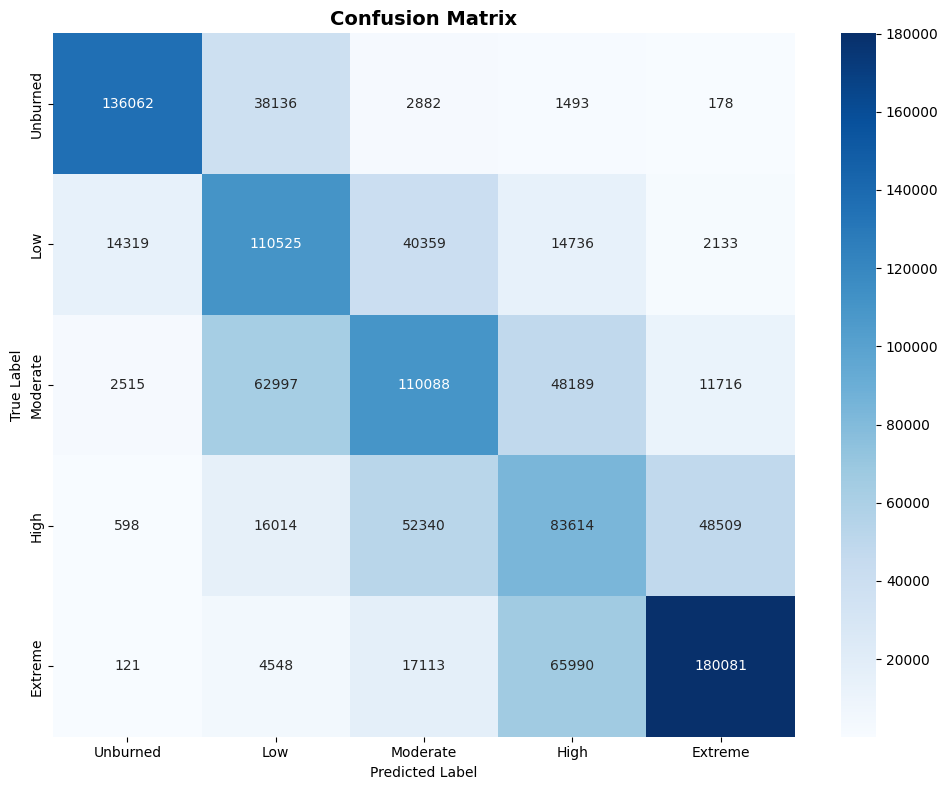


📸 Sample Predictions:

Sample 21:


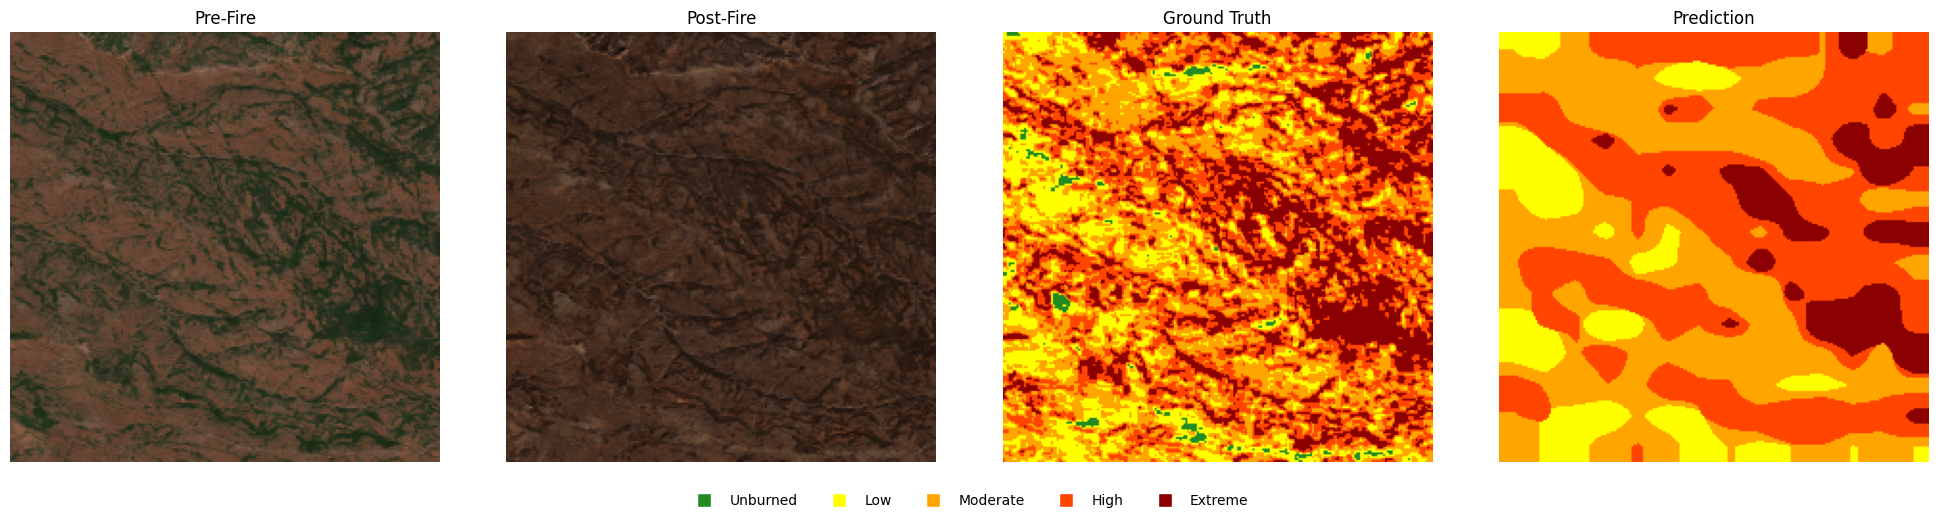


Sample 13:


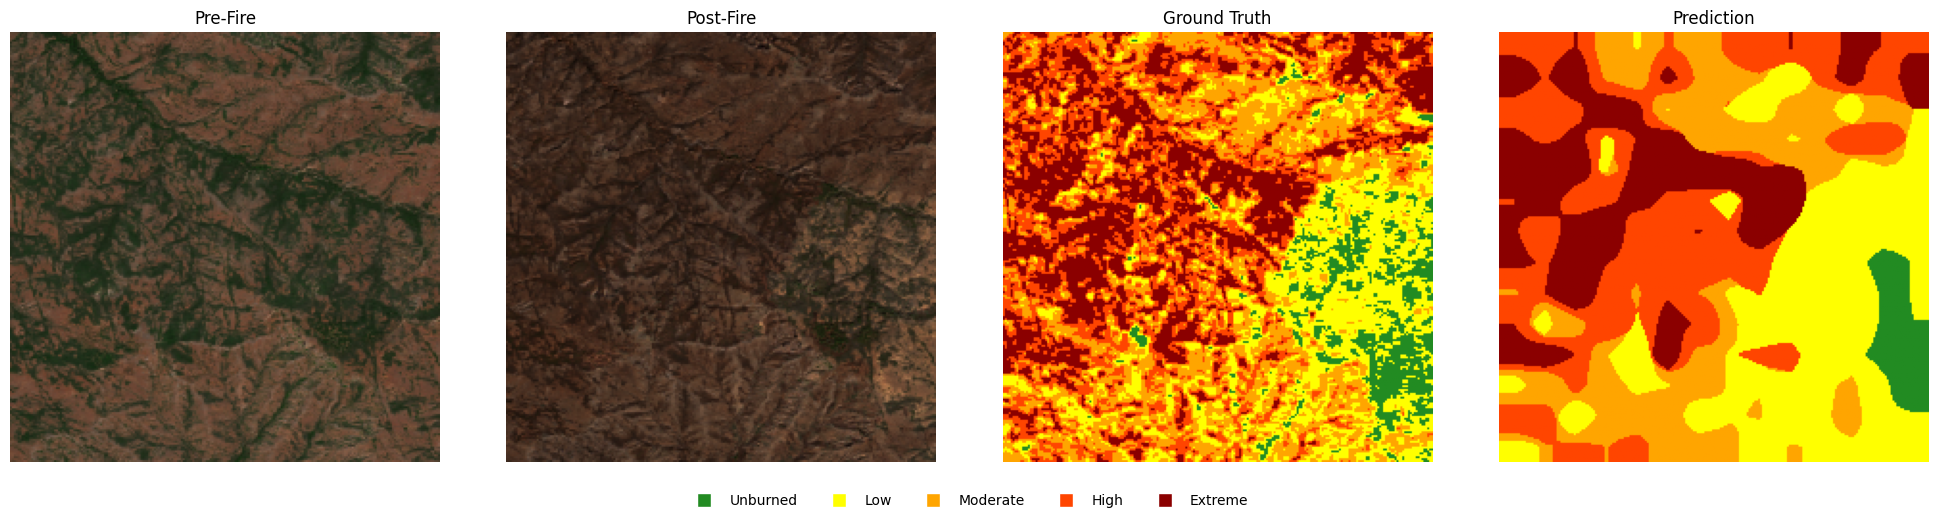


Sample 8:


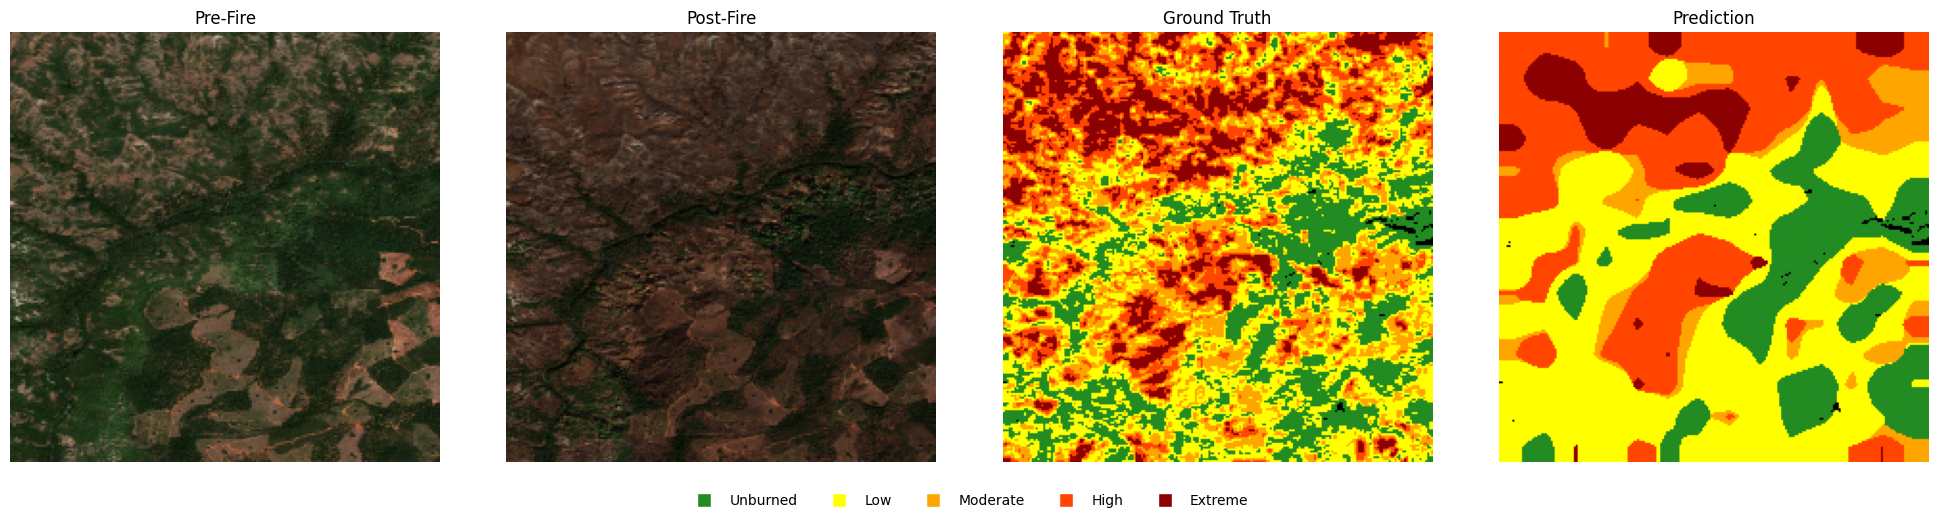


📊 SUMMARY STATISTICS
Unburned     - Pixels: 178,751 | Accuracy: 76.1%
Low          - Pixels: 182,072 | Accuracy: 60.7%
Moderate     - Pixels: 235,505 | Accuracy: 46.7%
High         - Pixels: 201,075 | Accuracy: 41.6%
Extreme      - Pixels: 267,853 | Accuracy: 67.2%

✅ Testing complete!
Files saved: confusion_matrix.png, prediction_*.png


In [ ]:
# ============================================================================
# SIMPLE INFERENCE - Copy-paste this into a new Colab cell
# ============================================================================

import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ============================================================================
# CONFIGURATION
# ============================================================================

CHECKPOINT_PATH = "/content/prithvi_checkpoints_delta/prithvi-delta-epoch=26-val_loss=1.435.ckpt"
DATA_DIR = "/content/data/prithvi_data_final_withdelta"

# ============================================================================
# LOAD MODEL
# ============================================================================

print("🔄 Loading model...")

# Recompute class weights (needed for loading)
class_weights = compute_class_weights(DATA_DIR)

# Load trained model
model = PrithviFireSegmentation.load_from_checkpoint(
    CHECKPOINT_PATH,
    class_weights=class_weights
)
model.eval()
model = model.cuda()

print("✅ Model loaded!\n")

# ============================================================================
# RUN PREDICTIONS ON VALIDATION SET
# ============================================================================

print("📊 Running predictions...")

# Setup data
data_module.setup()
val_loader = data_module.val_dataloader()

all_preds = []
all_targets = []
all_images = []

with torch.no_grad():
    for batch in val_loader:
        images = batch['image'].cuda()
        masks = batch['mask'].cuda()

        logits = model(images)
        preds = torch.argmax(logits, dim=1)

        all_images.append(images.cpu())
        all_preds.append(preds.cpu())
        all_targets.append(masks.cpu())

all_images = torch.cat(all_images)
all_preds = torch.cat(all_preds)
all_targets = torch.cat(all_targets)

print(f"✅ Got {all_preds.shape[0]} predictions\n")

# ============================================================================
# SHOW METRICS
# ============================================================================

# Filter ignore pixels
valid_mask = all_targets != 255
preds_flat = all_preds[valid_mask].numpy()
targets_flat = all_targets[valid_mask].numpy()

class_names = ['Unburned', 'Low', 'Moderate', 'High', 'Extreme']

print("="*80)
print("📊 CLASSIFICATION REPORT")
print("="*80)
print(classification_report(targets_flat, preds_flat, target_names=class_names, digits=4))

# ============================================================================
# VISUALIZE CONFUSION MATRIX
# ============================================================================

cm = confusion_matrix(targets_flat, preds_flat, labels=[0,1,2,3,4])

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

# ============================================================================
# VISUALIZE SAMPLE PREDICTIONS
# ============================================================================

def show_prediction(idx):
    """
    Visualize:
    Pre-fire | Post-fire | Ground Truth | Prediction
    """
    image = all_images[idx]      # (T=2, C=6, H, W)
    pred = all_preds[idx].numpy()
    target = all_targets[idx].numpy()

    # ---------------- RGB COMPOSITION ----------------
    # RGB = B4, B3, B2  → indices [2,1,0]
    pre_rgb  = image[0][[2,1,0]].permute(1,2,0).numpy()
    post_rgb = image[1][[2,1,0]].permute(1,2,0).numpy()

    # Contrast stretch for visualization
    pre_rgb  = np.clip(pre_rgb * 3.5, 0, 1)
    post_rgb = np.clip(post_rgb * 3.5, 0, 1)

    # ---------------- COLOR MAP ----------------
    class_names = ['Unburned', 'Low', 'Moderate', 'High', 'Extreme']
    colors = np.array([
        [34, 139, 34],    # Unburned - Green
        [255, 255, 0],    # Low       - Yellow
        [255, 165, 0],    # Moderate  - Orange
        [255, 69, 0],     # High      - Red-orange
        [139, 0, 0],      # Extreme  - Dark red
    ]) / 255.0

    # Handle ignore pixels (255)
    target_vis = target.copy()
    target_vis[target_vis == 255] = 0

    pred_rgb   = colors[pred]
    target_rgb = colors[target_vis]

    # Mask ignored GT pixels visually
    ignore_mask = target == 255
    target_rgb[ignore_mask] = [0, 0, 0]   # black
    pred_rgb[ignore_mask]   = [0, 0, 0]

    # ---------------- PLOT ----------------
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    axes[0].imshow(pre_rgb)
    axes[0].set_title("Pre-Fire", fontsize=12)
    axes[0].axis("off")

    axes[1].imshow(post_rgb)
    axes[1].set_title("Post-Fire", fontsize=12)
    axes[1].axis("off")

    axes[2].imshow(target_rgb)
    axes[2].set_title("Ground Truth", fontsize=12)
    axes[2].axis("off")

    axes[3].imshow(pred_rgb)
    axes[3].set_title("Prediction", fontsize=12)
    axes[3].axis("off")

    # ---------------- LEGEND ----------------
    handles = [
        plt.Line2D([0], [0], marker='s', color='w',
                   markerfacecolor=colors[i], markersize=10,
                   label=class_names[i])
        for i in range(5)
    ]

    fig.legend(
        handles=handles,
        loc="lower center",
        ncol=5,
        frameon=False,
        fontsize=10
    )

    plt.tight_layout(rect=[0, 0.08, 1, 1])
    plt.savefig(f"prediction_{idx}.png", dpi=150)
    plt.show()


# Show 3 random examples
print("\n📸 Sample Predictions:\n")
for i in np.random.choice(len(all_preds), 3, replace=False):
    print(f"Sample {i}:")
    show_prediction(i)
    print()

# ============================================================================
# SUMMARY STATISTICS
# ============================================================================

print("="*80)
print("📊 SUMMARY STATISTICS")
print("="*80)

for cls in range(5):
    mask = targets_flat == cls
    if mask.sum() > 0:
        accuracy = (preds_flat[mask] == cls).mean()
        print(f"{class_names[cls]:12} - Pixels: {mask.sum():>7,} | Accuracy: {accuracy:.1%}")

print("\n✅ Testing complete!")
print("Files saved: confusion_matrix.png, prediction_*.png")

In [ ]:
#download the checkpoint
import shutil
from google.colab import files

folder_to_download = "/content/prithvi_checkpoints_delta"
output_filename = "prithvi_checkpoints_delta.zip"

# Create a zip archive of the folder
shutil.make_archive(folder_to_download, 'zip', folder_to_download)

# Download the zip file
files.download(output_filename)

print(f"✅ Folder '{folder_to_download}' has been zipped to '{output_filename}' and download initiated.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Folder '/content/prithvi_checkpoints_delta' has been zipped to 'prithvi_checkpoints_delta.zip' and download initiated.
